In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, roc_auc_score,roc_curve,
                            ConfusionMatrixDisplay, auc,
                            precision_score, recall_score, f1_score)

In [2]:
# Download the zipped data set
import gdown
file_id = "1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"

gdown.download(url, output, quiet=False)

!unzip -q data.zip -d data

Downloading...
From (original): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti
From (redirected): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti&confirm=t&uuid=1a7af705-b5d0-4ec5-b25f-3cc18626e0b7
To: /kaggle/working/data.zip
100%|██████████| 110M/110M [00:01<00:00, 75.7MB/s] 


In [3]:
# 1. Set the folder path
# --------------------------------------------------
train_REAL = "data/train/REAL"
train_FAKE = "data/train/FAKE"
test_REAL = "data/test/REAL"
test_FAKE = "data/test/FAKE"

In [4]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


In [5]:
# Normalize pixels to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Flatten images
X_train_flat = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flat = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

print(f"Train shape: {X_train_flat.shape}")  # (100000, 3072)
print(f"Test shape: {X_test_flat.shape}")    # (20000, 3072)

Train shape: (100000, 3072)
Test shape: (20000, 3072)


In [6]:
USE_FULL_DATASET = False  # Set to False to use subset

if USE_FULL_DATASET:
    X_train_final = X_train_flat
    y_train_final = y_train
    X_test_final = X_test_flat
    y_test_final = y_test
else:
    X_train_final, _, y_train_final, _ = train_test_split(
        X_train_flat, y_train,
        train_size=20000,
        stratify=y_train,
        random_state=42
    )
    X_test_final, _, y_test_final, _ = train_test_split(
        X_test_flat, y_test,
        train_size=5000,
        stratify=y_test,
        random_state=42
    )
    print(f"\nUsing reduced dataset:")
    print(f"Train shape: {X_train_final.shape}")
    print(f"Test shape: {X_test_final.shape}")


Using reduced dataset:
Train shape: (20000, 3072)
Test shape: (5000, 3072)


In [11]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_final, y_train_final,
    test_size=0.2,
    stratify=y_train_final,
    random_state=42
)
print(f"Training set: {X_train_sub.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (16000, 3072)
Validation set: (4000, 3072)


In [12]:
xgb_model = xgb.XGBClassifier(
    # Tree parameters
    n_estimators=200,           # Number of trees
    max_depth=8,                # Maximum tree depth
    learning_rate=0.05,         # Step size shrinkage

    # Sampling parameters
    subsample=0.8,              # Row sampling per tree
    colsample_bytree=0.8,       # Feature sampling per tree
    colsample_bylevel=0.8,      # Feature sampling per level

    # Regularization
    min_child_weight=3,         # Minimum sum of instance weight in child
    gamma=0.1,                  # Minimum loss reduction for split
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization

    # Other parameters
    objective='binary:logistic', # Binary classification
    eval_metric='logloss',      # Evaluation metric
    random_state=42,
    tree_method='hist',         # Fast histogram-based method
    n_jobs=-1,                  # Use all CPU cores
    early_stopping_rounds=10    # Stop if no improvement for 10 rounds
)

In [15]:
%%time
# Train with validation monitoring
xgb_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=20  # Print every 20 iterations
)

[0]	validation_0-logloss:0.67693	validation_1-logloss:0.68182
[20]	validation_0-logloss:0.47660	validation_1-logloss:0.55121
[40]	validation_0-logloss:0.38837	validation_1-logloss:0.49851
[60]	validation_0-logloss:0.33847	validation_1-logloss:0.47139
[80]	validation_0-logloss:0.30219	validation_1-logloss:0.45104
[100]	validation_0-logloss:0.27466	validation_1-logloss:0.43561
[120]	validation_0-logloss:0.24987	validation_1-logloss:0.42273
[140]	validation_0-logloss:0.22728	validation_1-logloss:0.41253
[160]	validation_0-logloss:0.20862	validation_1-logloss:0.40407
[180]	validation_0-logloss:0.19039	validation_1-logloss:0.39664
[199]	validation_0-logloss:0.17643	validation_1-logloss:0.39084
CPU times: user 8min 57s, sys: 3.38 s, total: 9min
Wall time: 5min 28s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [16]:

y_train_pred = xgb_model.predict(X_train_final)
y_test_pred = xgb_model.predict(X_test_final)

# Get prediction probabilities
y_test_proba = xgb_model.predict_proba(X_test_final)[:, 1]

In [17]:
class_names = ['Fake', 'Real']

In [18]:
print(classification_report(y_train_final, y_train_pred,
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.9543    0.9330    0.9435     10000
        Real     0.9345    0.9553    0.9448     10000

    accuracy                         0.9442     20000
   macro avg     0.9444    0.9442    0.9441     20000
weighted avg     0.9444    0.9442    0.9441     20000



In [19]:
print(classification_report(y_test_final, y_test_pred,
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.8235    0.8380    0.8307      2500
        Real     0.8351    0.8204    0.8277      2500

    accuracy                         0.8292      5000
   macro avg     0.8293    0.8292    0.8292      5000
weighted avg     0.8293    0.8292    0.8292      5000



In [20]:
xgb_model2 = xgb.XGBClassifier(
    # Tree parameters
    n_estimators=200,           # Number of trees
    max_depth=10,                # Maximum tree depth
    learning_rate=0.05,         # Step size shrinkage

    # Sampling parameters
    subsample=0.8,              # Row sampling per tree
    colsample_bytree=0.8,       # Feature sampling per tree
    colsample_bylevel=0.8,      # Feature sampling per level

    # Regularization
    min_child_weight=3,         # Minimum sum of instance weight in child
    gamma=0.1,                  # Minimum loss reduction for split
    reg_alpha=0,              # L1 regularization
    reg_lambda=5,             # L2 regularization

    # Other parameters
    objective='binary:logistic', # Binary classification
    eval_metric='logloss',      # Evaluation metric
    random_state=42,
    tree_method='hist',         # Fast histogram-based method
    n_jobs=-1,                  # Use all CPU cores
    early_stopping_rounds=10    # Stop if no improvement for 10 rounds
)

In [21]:
%%time
# Train with validation monitoring
xgb_model2.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=20  # Print every 20 iterations
)

[0]	validation_0-logloss:0.67526	validation_1-logloss:0.68078
[20]	validation_0-logloss:0.45820	validation_1-logloss:0.54576
[40]	validation_0-logloss:0.36143	validation_1-logloss:0.49189
[60]	validation_0-logloss:0.31026	validation_1-logloss:0.46336
[80]	validation_0-logloss:0.27375	validation_1-logloss:0.44290
[100]	validation_0-logloss:0.24220	validation_1-logloss:0.42734
[120]	validation_0-logloss:0.21541	validation_1-logloss:0.41418
[140]	validation_0-logloss:0.19162	validation_1-logloss:0.40380
[160]	validation_0-logloss:0.17184	validation_1-logloss:0.39622
[180]	validation_0-logloss:0.15398	validation_1-logloss:0.38875
[199]	validation_0-logloss:0.13782	validation_1-logloss:0.38213
CPU times: user 12min 36s, sys: 8.06 s, total: 12min 44s
Wall time: 7min 40s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [22]:

y_train_pred2 = xgb_model2.predict(X_train_final)
y_test_pred2 = xgb_model2.predict(X_test_final)

In [23]:
print(classification_report(y_train_final, y_train_pred2,
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.9617    0.9500    0.9558     10000
        Real     0.9506    0.9622    0.9564     10000

    accuracy                         0.9561     20000
   macro avg     0.9562    0.9561    0.9561     20000
weighted avg     0.9562    0.9561    0.9561     20000



In [24]:
print(classification_report(y_test_final, y_test_pred2,
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.8319    0.8572    0.8444      2500
        Real     0.8527    0.8268    0.8396      2500

    accuracy                         0.8420      5000
   macro avg     0.8423    0.8420    0.8420      5000
weighted avg     0.8423    0.8420    0.8420      5000



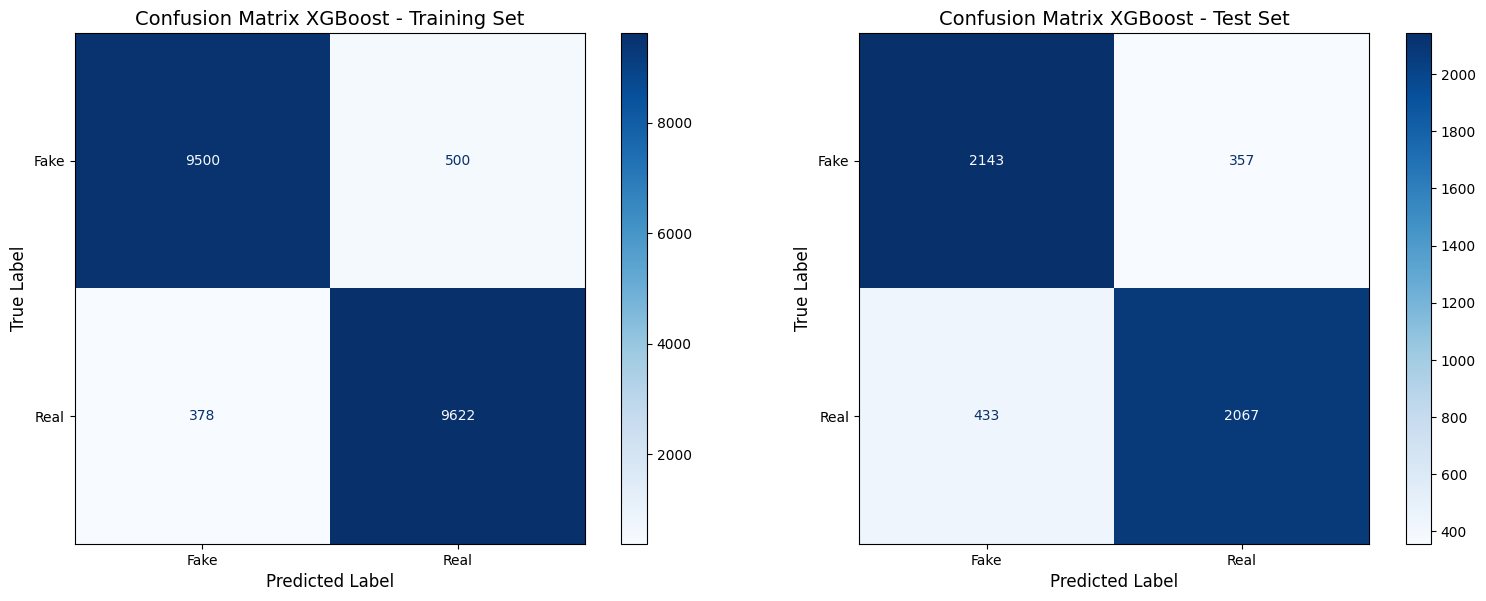

In [25]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train_final, y_train_pred2)
cm_test = confusion_matrix(y_test_final, y_test_pred2)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                     display_labels=class_names)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix XGBoost - Training Set', fontsize=14)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].grid(False)

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                    display_labels=class_names)
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Confusion Matrix XGBoost - Test Set', fontsize=14)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].grid(False)

plt.tight_layout()
plt.show()

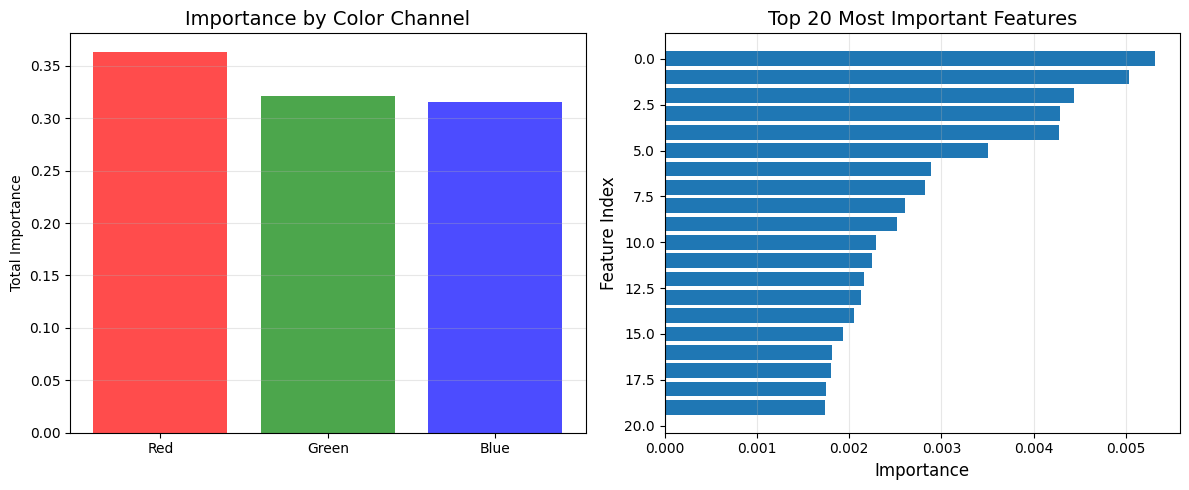

In [26]:
# Get feature importance
importance = xgb_model.feature_importances_

# Reshape back to image dimensions for visualization
importance_img = importance.reshape(32, 32, 3)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Per channel
channel_importance = [importance_img[:, :, i].sum() for i in range(3)]
axes[0].bar(['Red', 'Green', 'Blue'], channel_importance, color=['red', 'green', 'blue'], alpha=0.7)
axes[0].set_title("Importance by Color Channel", fontsize=14)
axes[0].set_ylabel("Total Importance")
axes[0].grid(axis='y', alpha=0.3)

# Top features
top_n = 20
top_indices = np.argsort(importance)[-top_n:][::-1]
axes[1].barh(range(top_n), importance[top_indices])
axes[1].set_xlabel("Importance", fontsize=12)
axes[1].set_ylabel("Feature Index", fontsize=12)
axes[1].set_title(f"Top {top_n} Most Important Features", fontsize=14)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

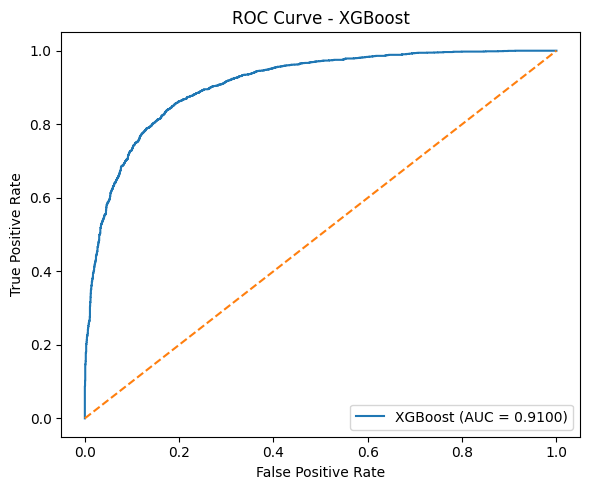

In [27]:
y_prob_xgb = xgb_model.predict_proba(X_test_final)[:, 1]

# Calculate ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_final, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

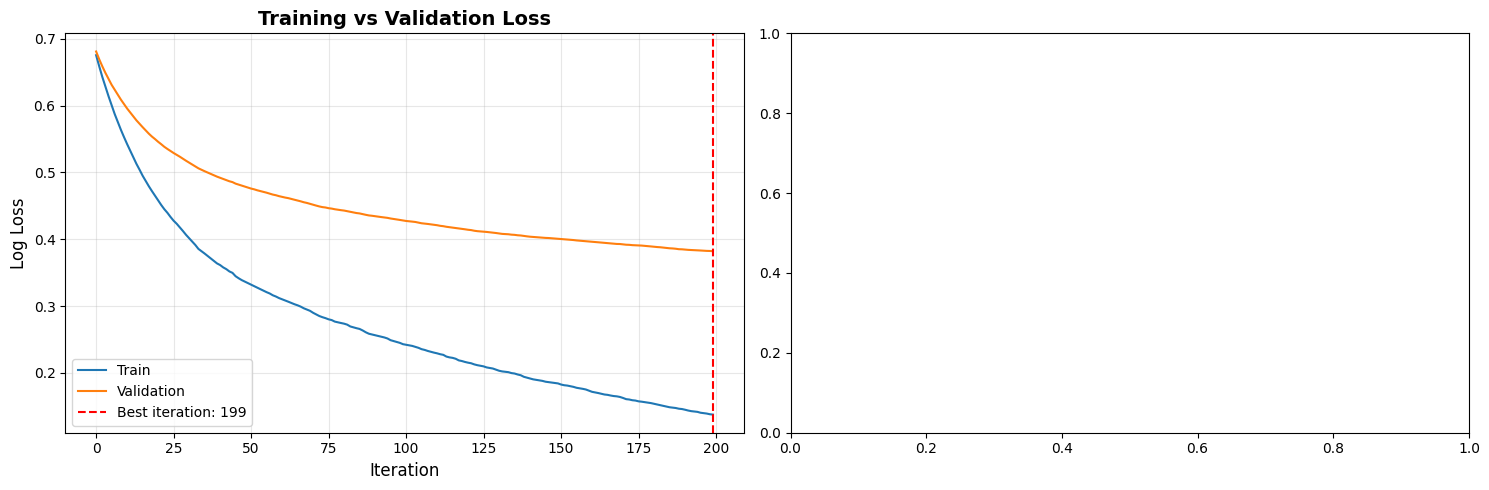

In [28]:
results = xgb_model2.evals_result()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(results['validation_0']['logloss'], label='Train')
axes[0].plot(results['validation_1']['logloss'], label='Validation')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Log Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Best iteration marker
best_iteration = xgb_model.best_iteration
axes[0].axvline(x=best_iteration, color='r', linestyle='--',
                label=f'Best iteration: {best_iteration}')
axes[0].legend()

# # Accuracy over iterations (calculate from predictions)
# train_sizes = range(10, len(X_train_sub) + 1, len(X_train_sub) // 10)
# train_scores = []
# val_scores = []

# for size in train_sizes:
#     temp_model = xgb.XGBClassifier(n_estimators=100, max_depth=8,
#                                     learning_rate=0.05, random_state=42,
#                                     tree_method='hist', n_jobs=-1)
#     temp_model.fit(X_train_sub[:size], y_train_sub[:size])
#     train_scores.append(temp_model.score(X_train_sub[:size], y_train_sub[:size]))

# axes[1].plot(train_sizes, train_scores, 'o-', label='Train', alpha=0.8)
# axes[1].plot(train_sizes, val_scores, 'o-', label='Validation', alpha=0.8)
# axes[1].set_xlabel('Training Set Size', fontsize=12)
# axes[1].set_ylabel('Accuracy', fontsize=12)
# axes[1].set_title('Learning Curve', fontsize=14, fontweight='bold')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
xgb_model2.save_model("xgb_model2.json")

In [11]:
# Create a new model instance
xgb_model2 = xgb.XGBClassifier()  # or XGBRegressor

# Load the model from file
xgb_model2.load_model("/kaggle/input/xgboost/scikitlearn/default/1/xgb_model2.json")

In [13]:
import shap
import numpy as np

# Model prediction function
def model_predict(x):
    return xgb_model2.predict_proba(x)

# Background sample for KernelExplainer
background = shap.sample(X_train_final, 50)

# Create the explainer on the full pipeline
explainer = shap.KernelExplainer(model_predict, background)

# Pick data to explain
X_test_sample = X_test_final[:10]

# Compute SHAP values in PCA space
shap_pca = explainer.shap_values(X_test_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
def showPixelMean_RGB(img, title):
  R = img[:, :, 0]
  G = img[:, :, 1]
  B = img[:, :, 2]

  zeros = tf.zeros_like(R)

  red_only   = tf.stack([R, zeros, zeros], axis=-1)
  green_only = tf.stack([zeros, G, zeros], axis=-1)
  blue_only  = tf.stack([zeros, zeros, B], axis=-1)

  plt.figure(figsize=(10, 4))
  plt.suptitle(title, fontsize=16)

  plt.subplot(1, 3, 1)
  plt.imshow(R, cmap="seismic")
  plt.title("Red Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.subplot(1, 3, 2)
  plt.imshow(G, cmap="seismic")
  plt.title("Green Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.subplot(1, 3, 3)
  plt.imshow(B, cmap="seismic")
  plt.title("Blue Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.show()

In [29]:
shap_arr = np.array(shap_pca)

In [35]:
shap_arr = np.array(shap_pca)
arr_reordered = np.transpose(shap_arr, (1, 2, 0)) 
arr_reordered[0].shape

(3072, 2)

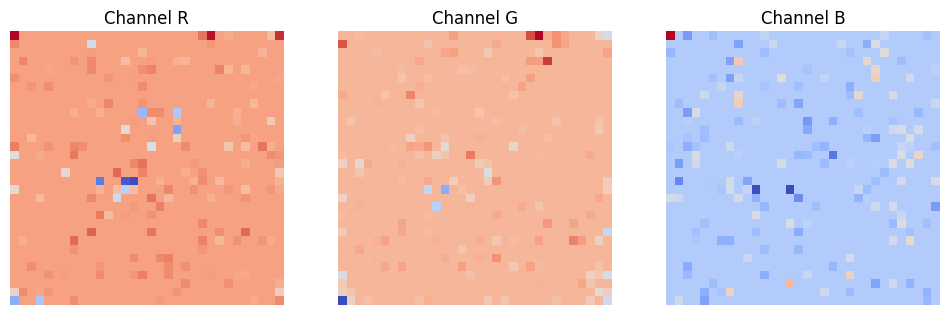

In [49]:
import numpy as np  
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation  

# Example: shap_values of shape (10, 3072, 2)  
class_index = 1  
shap_class = arr_reordered[:, :, class_index]  # (10, 3072)  

# Reshape all images to (10, 32, 32, 3)  
shap_images = shap_class.reshape(-1, 32, 32, 3)  

# Normalize function  
def normalize_image(img):  
    img_min = img.min()  
    img_max = img.max()  
    if img_max - img_min == 0:  
        return np.zeros_like(img)  
    return (img - img_min) / (img_max - img_min)  

# Setup figure  
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  
im_list = [axes[i].imshow(normalize_image(shap_images[0][:,:,i]), cmap='coolwarm') for i in range(3)]  

for ax, ch in zip(axes, ['R', 'G', 'B']):  
    ax.axis('off')  
    ax.set_title(f"Channel {ch}")  

# Animation update function  
def update(frame):  
    for i in range(3):  
        im_list[i].set_data(normalize_image(shap_images[frame][:,:,i]))  
    fig.suptitle(f"Image {frame} SHAP for class {class_index}", fontsize=16)  
    return im_list  

# Create animation WITHOUT blit to ensure proper looping  
anim = FuncAnimation(fig, update, frames=10, interval=500, repeat=True, blit=False)  

plt.show()  

In [1]:
shap_image = arr_reordered[2][:,1].reshape(32, 32, 3)
showPixelMean_RGB(shap_image,"SHAP of XGBoost")

NameError: name 'arr_reordered' is not defined

In [14]:
shap_pca[0].shape

(3072, 2)